<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2

### <center> Автор материала: Андрей Гуревич, andrey.a.gurevich@gmail.com

## <center> Индивидуальный проект по анализу данных </center>
## <center> Автоматический классификатор обращений в техподдержку </center>

###  Часть 1. Описание набора данных и признаков

#### Примечание
В тексте будет часто встречаться фраза "по ряду причин". И причины эти раскрываться не будут, потому что они либо очень пространны в изложении и не имеют никакого отношения к машинному обучению, либо попадают под положение о коммерческой тайне.

Исходные данные также попадают под положение о коммерческой тайне, поэтому не могут быть распространены. Как следствие, ноутбук не является воспроизводимым без исходных данных.
#### Цель работы
Автоматическая классификация обращений в техподдержку вместо используемого сейчас ручного труда.
#### Описание ситуации
* От пользователей поступает примерно 3000 обращений в месяц в техподдержку по различным каналам (телефон, почта, самостоятельная регистрация через ServiceDesk). Все эти обращения вручную классифицируются (зачем человек обратился) и маршрутизируются (кто будет делать).
* Недавно произошла смена программной платформы ServiceDesk с одного продукта (CA Service Desk) на другой (ServiceNow). Поэтому большая историческая база заявок у нас есть в одной системе, а новые заявки обрабатывать надо в другой
* При смене платформы произошла полная смена классификатора. В старой было дерево предметных областей. В новой - дерево услуг, у каждой из которых есть категория, а у части - ещё подкатегория. При таком изменении подхода возникло несколько типов ситуаций:
    * По некоторым предметным областям работы в новой системе просто не ведутся.
    * У некоторых предметных областей из старой системы есть однозначное соответствие связки "услуга-категория-подкатегория" в новой.
    * У многих произошло разбиение на 2-3 категории. Например, был "Удалённый доступ через VPN". Он превратился в "Предоставление VPN", "Продление VPN", "Поддержка VPN". Смысл разбиения: предоставление надо согласовывать со Службой информационной безопасности, продление - нет, а поддержкой занимаются совсем другие люди.
    * Новый классификатор основан на услугах для пользователя, он ещё в процессе доработки, поэтому возникают ситуации дублирования. Например, когда пользователю надо установить клиент для VPN-подключения, это вроде бы "Установка прочего ПО". Но "Поддержка VPN" тоже подходит. Это сильно повлияет на оценку точности модели.
* При смене платформы также инженеры получили возможность переназначить заявку, не меняя значение классификатора. В старой системе такого не было. Это сильно повысило удобство работы в системе. Но, как следствие, мы получили много заявок с неправильным выбранным значением услуги. Очевидная идея переклассифицировать существующие заявки по последнему решавшему не работает по ряду причин (не будем на них останавливаться). Так что при обработке данных значительная часть работы заключается в корректной переклассификации заявок в новую систему услуг-категорий-подкатегорий.

#### Входные данные и постановка задачи
Входные данные - письмо пользователя с описанием проблемы. На первом этапе внедрения обрабатываются только входящие письма, т.е. у нас есть заголовок письма, тело письма и его автор. 

На выходе надо получить:
* Классификацию (услуга, категория, подкатегория).
* Признак срочности (надо ли эту заявку решать раньше прочих).
* Метрику уверенности в классификации.

Особенность постановки задачи в том, что допускается ответ классификатора "я не знаю". Более того, этот ответ лучше, чем ошибочная классификация. Следствия такой постановки:
* Можно игнорировать редкие классы, если модель на них будет выдавать ответ "я не знаю". Данные сильно несбалансированы (на этом остановимся позже), так что такая возможность сильно упрощает задачу.
* Требуется соблюсти некий баланс между количеством заявок, по которым модель даёт уверенный ответ и количеством ошибок при этом. 

###  Часть 2. Первичный анализ признаков

In [19]:
import pandas as pd
import numpy as np
pd.options.display.max_colwidth = 500
pd.options.display.max_columns = 500
pd.options.display.max_rows = 999

from functools import lru_cache

import re
from sklearn.externals import joblib

from tqdm._tqdm_notebook import tqdm_notebook as tqdm
tqdm.pandas()

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams.update({'font.size': 14})

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection  import StratifiedKFold
from sklearn.model_selection  import GridSearchCV
from sklearn.model_selection  import cross_val_score

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from time import time

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


import warnings
warnings.filterwarnings('ignore')

make_cv=True

Данные о заявках можно получать двумя основными способами:
* подключаться напрямую к БД и забирать данные оттуда
* сделать предварительную выгрузку в Excel и работать уже с ней.

У первого пути меньше лишних телодвижений, зато второй позволяет зафиксировать набор данных. Это важно в той ситуации, когда мы ищем оптимальный способ предварительной их трансформации перед обучением. 

In [20]:
df_snow = pd.read_excel("data/raw_export_snow_2017-11-09.xlsx")
df_snow.columns

Index(['Номер', 'Тип контакта', 'Краткое описание', 'Описание',
       'Бизнес-услуга', 'Категория', 'Подкатегория', 'Пользователь',
       'Приоритет', 'Состояние', 'Группа назначения', 'Кому назначено',
       'Создано'],
      dtype='object')

Признаки, которые нас интересуют на первом этапе - 'Краткое описание', 'Описание', 'Бизнес-услуга', 'Категория', 'Подкатегория'.
При этом мы из предметной области знаем, что Описание и Подкатегория могут быть пустыми, а остальные нужные поля - нет.

In [21]:
df_snow.describe().drop(["top","first","last"],axis=0)

,Номер,Тип контакта,Краткое описание,Описание,Бизнес-услуга,Категория,Подкатегория,Пользователь,Приоритет,Состояние,Группа назначения,Кому назначено,Создано
count,10000,7724,10000,9973,10000,10000,2801,10000,10000,10000,10000,9992,10000
unique,10000,5,8629,9679,42,110,60,1322,4,5,45,57,9990
freq,1,6302,33,17,3657,1047,325,85,8573,9012,1988,810,2


*describe* это подтверждает, здесь никаких сюрпризов.

Визуальный анализ длины описания будет проведён уже после обработки

###  Части 4, 5. Закономерности, "инсайты", особенности данных. Предобработка данных.

Названия столбцов соответствуют названиям в интерфейсе ServiceNow. Но нам удобней работать с несколько иной структурой: 
* в первую очередь, надо склеить услугу, категорию и подкатегорию;
* у заявки есть 'Краткое описание' и 'Описание' (полное). Бывают такие ситуации, когда краткое представляет из себя первые N символов полного, а бывают такие, что в кратком описании содержится очень важная информация, которой нет в полном описании. поэтому их надо склеить, избежав дублирования
* столбцы, которые пока не участвуют в модели, удалим

In [22]:
def merge_summary_and_description(row):
    #print(row["summary"])
    
    if row["description"][:len(row["summary"])+1] == row["summary"]:
        return row["description"]
    else:
        return row["summary"] + " " + row["description"]


df_snow.rename(columns={"Номер":"ref_num", 
                        "Краткое описание":"summary", 
                        "Описание":"description",
                        'Группа назначения':"AssignGroup"
                       }, inplace = True)


df_snow["description"].fillna(" ",inplace=True)

df_snow["category"] = df_snow["Бизнес-услуга"].fillna("") + "@" + df_snow["Категория"].fillna("") + "@" + df_snow["Подкатегория"].fillna("")
df_snow["raw_description"] = df_snow.apply(merge_summary_and_description, axis=1)

df_snow["raw_description"].fillna(" ", inplace=True)

df_snow.drop(['summary', 'description', 
              'Бизнес-услуга', 'Категория', 'Подкатегория', 
              'Пользователь', 'Приоритет','Состояние',
              'Кому назначено', 'Создано'], axis=1, inplace = True)



In [23]:
df_snow.columns

Index(['ref_num', 'Тип контакта', 'AssignGroup', 'category',
       'raw_description'],
      dtype='object')

Внедрение ServiceNow произошло недавно, так что для обучения у нас заявок не так уж и много:

In [24]:
print("Количество заявок из ServiceNow:", df_snow.shape[0])

Количество заявок из ServiceNow: 10000


Из-за режима КТ придётся сделать таблицу с примерами, заменив в них чувствительную информацию



|   |ref_num|category|raw_description|
|:-:|:--|---|---|
|0| T0  |Удалённый доступ к внутренним ресурсам@Электронная почта@Доступ к почте с мобильных устройств|Просьба предоставить доступ к почте через мобильное устройство|
|1| T1  |ERP@Служебные записки@СЗ на оплату (безналичная и наличная)|>>: СЗ оплата обеспечения Письмо от: Username@companyname.com\n\nКоллеги, посмотрите пож-та маршрут согласования этой СЗ.\nПодобные СЗ НЕ должны попадать на согласование к Иванову Ивану.\n\nС уважением,\nСмирнова Светлана\nНачальник управления по управлению всеми управлениями\nДепартамент управления всеми управлениями\n\nT: +7 (800) 123 4567, доб.0000\nМ: +7 (800) 123 4567\nUsername@companyname.com\nwww.companyname.com\n\nДанное электронное письмо содержит информацию, составляю...|
|2| T2  |Электронная почта@Прочие проблемы с электронной почтой@|почта с личных e-mail Письмо от: Username@companyname.com\n\nКоллеги, добрый день.\n\nНе могли бы Вы отключить блокировку писем с частных адресов.\nТочно знаю, что мне было отправлено письмо от адресата user@example.com., но оно до меня не дошло.\n\nИли пусть хотя бы приходит сообщение о том, что "получено письмо, оставить\nего в блоке или пропустить".\nЭто возможно?\n\nСпасибо.\nС уважением,\nТарасова Прасковья\nЗаместитель начальника Отдела учёта\nДепартамента по работе с документами\n\n\nB: +7...|


Основные проблемы того, что мы получили в **raw_description**:
* огромные блоки "С уважением, бла-бла-бла"
* после которых идёт идёт абзац про коммерческую тайну в стиле "Если вы получили это письмо по ошибке - не надо было его читать"
* ServiceNow этот абзац при обработке почты разбивает переносами строки на несколько, так что вырезать регулярками 1 абзац, в котором есть выражение "коммерческая тайна" нельзя.
* вариантов этого текста около 10
* некоторые слова из него могут быть важными маркерами для категоризации, так что выкинуть все это слова через stop-list тоже нельзя
* есть куча мусора в виде e-mail адресов, артефактов переписки типа "Re: Re> на: ha>> fw :" и т.д.
* номера телефонов нам тоже не нужны

Чем можно воспользоваться:
* Номера документов имеют фиксированный формат и иногда по номеру понятно, к какому разделу ERP документ относится. Заменим их по формату на токены, DOCBUH, DOCLOGISTIC. Очевидно, что для задачи классификации информация "в заявке указан номер бухгалтерского документа" полезнее, чем сам номер.
* IP и MAC адреса, также заменяем на фиксированные токены: IPADDRESS, MACADDRESS

In [25]:
cleaning_dict = {
    "\sстаф\s": " estaff ",
    "\sестафф\s": " estaff ",
    "\|":" ",
    " +": " ",
    'с уважением,{0,1}(\s{1,2}.+){3}': " ",
    "\w+ [A-Z]( [\w/]+@)TSAS+": " ",
    "[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+": " ",
    "(письмо от:.+)|(от: .+)|(кому: .+)|(копия: .+)|(дата: .+)|(т: .+)": " ",
    "(м: .+)|(тел\.{0,1}:{0,1} .+)|(phone: .+)|(mobile: .+)|(факс: .+)|(tel: .+)": " ",
    "(fax: .+)|(моб: .+)|(from: .+)|(sent: .+)|(to: .+)|(cc: .+)|(t: .+)|(m: .+)": " ",
    "(тел\. .+)|(моб\.: .+)|(моб\. .+)": " ",
    "(данное\sэлектронное)([\s\S]+?)(к\sнему\sфайлы\s\(при\sих\sналичии\))([\s\S]+?)(к\sнему\sфайлы)": " ", 
    "([A-Z])([a-z])+( )([A-Z])( )([A-Z])([a-z])+": " ",
    "\d{2}\.\d{2}\.\d{2,4} \d{2}:\d{2}\s": "datetoken",
    "(\d){1,2}([\.\/-])(\d){1,2}([\.\/-])(\d){2,4}(\s(\d){1,2}(:\d\d){1,2})?": "datetoken",
    "(\d){1,2}([ \.\/-])(январ(я|ь)|феврал(я|ь)|март(а)?|апрел(я|ь)|ма(я|й)|июн(я|ь)|июл(я|ь)|август(а)?|сентябр(я|ь)|октябр(я|ь)|ноябр(я|ь)|декабр(я|ь))([ \.\/-])(\d){2,4}(г)?": "datetoken",
    "9-\d{1,4}[- ]{1,2}\d{1,3}": "SPPNUMBER",
    "\d{1,3}(\.\d{1,3}){1,5},\d{2}": "moneytoken",
    #"[^ A-Za-zА-Яа-я0-9]": " ",
    "(re:)|(ha: )|(ha: )|(hа: )|(на: )|(re )|(ha )|(ha )|(hа )|(на )": " ",
    "nul": " ",
    "(\sбпм\s)|(\sврм\s)": " bpm ",
    "добрый день": " ",
    "(\d(1,3))(\.)(\d(1,3))(\.)(\d(1,3))(\.)(\d(1,3))|(ip)": "IPADDRESS",
    "([0-9A-Fa-f]{2}[.:-]?){5}([0-9A-Fa-f]{2})": "MACADDRESS",
    "(\d{6}-\d{3})": "opportunitynumber",
    "(\sopp\s)|(\soppty\s)|(\sорра\s)": "opportunity",
    "(access\.technoserv\.cloud)": "accesstechnoservcloud",
    "(15[0-9]{8})|(21[0-9]{8})|(24[0-9]{8})|(40[0-9]{8})|(68[0-9]{8})|(70[0-9]{8})|(71[0-9]{8})": "DOCBUH",
    "(18[0-9]{8})|(28[0-9]{8})|(45[0-9]{8})|(49[0-9]{8})": "DOCLOGISTIC",
    "({)|(})": " ",
    "(www\.ts-cloud\.ru)|(www\.technoserv\.com)": " ",
    "\sconfluens\s": " confluence ",
    "Отправлено с моего iPhone с помощью IBM Verse": " ",
    "Отправлено из IBM Verse": " ",
    "Sent from my iPhone using IBM Verse": " ",
    "Sent using IBM Verse": " ",
    "Отправлено с моего iPad с помощью IBM Verse": " ",
    "\sсап\s": " sap ",
    "\t": " ",
    "\n": " "
}

def remove_multispaces(x):
    return re.sub(pattern=" +",repl=" ",string=x,count=0)

def remove_brackets(x):
    return re.sub(pattern="({)|(})",repl=" ",string=x,count=0)

df_snow["text"] = df_snow["raw_description"].str.lower()
df_snow.replace(to_replace = {"text": cleaning_dict}, inplace = True, regex=True )

Сейчас в столбцах text у нас частично очищенное от мусора описание заявки со всем многообразием словоформ русского языка. Чтобы от этого многообразия избавиться, надо провести лемматизацию.
В качестве лемматизатора рассматривалось два варианта: pymystem и pymorphy.
pymorphy очень удобен в использовании, очень быстр (особенно с lru_cache) но недостаточно сильно снижает многообразие словоформ.
pymystem довольно жёсткий (лемматизирует то, что pymorphy уже считает леммой), быстрый в linux, но имеет очень большие накладные расходы (~0.7 секунды) на запуск под windows. Т.е. обрабатывать им слова по одному - дело долгое. Зато можно все тексты слить в один файл и его обработка пройдет довольно быстро. Кроме того, в качестве параметра можно подготовить fixlist, в котором заменять всякие сокращения и популярные опечатки. Важный минус - он просто игнорирует всю латиницу.

In [26]:
df_snow["text"].to_csv("data/df_snow_text.csv", encoding="utf-8")
!"C:\Users\agurevich\.local\bin\mystem" -cdl --fixlist C:\Users\agurevich\python\moose\data\ts_fixlist.txt C:\Users\agurevich\python\moose\data\df_snow_text.csv C:\Users\agurevich\python\moose\data\df_snow_text.out
df_snow["text"] = pd.read_csv("data/df_snow_text.out", header=None)[1]
df_snow["text"] = df_snow["text"].apply(remove_brackets)
df_snow["text"] = df_snow["text"].apply(remove_multispaces)

Посмотрим, что у нас получилось:

|   |ref_num|category|raw_description|text|
|:-:|:--|---|---|---|
|0| T0  |Удалённый доступ к внутренним ресурсам@Электронная почта@Доступ к почте с мобильных устройств|Просьба предоставить доступ к почте через мобильное устройство|{просьба} {предоставлять} {доступ} {к} {почта} {через} {мобильный} {устройство}|
|1| T1  |ERP@Служебные записки ERP@СЗ на оплату (безналичная и наличная)|>>: СЗ оплата обеспечения Письмо от: Username@companyname.com\n\nКоллеги, посмотрите пож-та маршрут согласования этой СЗ.\nПодобные СЗ НЕ должны попадать на согласование к Иванову Ивану.\n\nС уважением,\nСмирнова Светлана\nНачальник управления по управлению всеми управлениями\nДепартамент управления всеми управлениями\n\nT: +7 (800) 123 4567, доб.0000\nМ: +7 (800) 123 4567\nUsername@companyname.com\nwww.companyname.com\n\nДанное электронное письмо содержит информацию, составляю...|>>: {сз} {оплата} {обеспечение} {коллега}, {посмотреть} {пожа?}-{тот} {маршрут} {согласование} {этот} {сз}. {подобный} {сз} {не} {должный} {попадать} {согласование} {к} {иванов} {иван}. {www??}.{companyname??}.{com??} ----- {пересылать}:  ----- {тема}: {сз} {оплата} {обеспечение} {средство} {для} {обеспечение} {участие} {в} {электронный} {процедура}. {ндс} {не}...|
|2| T2  |Электронная почта@Прочие проблемы с электронной почтой@|почта с личных e-mail Письмо от: Username@companyname.com\n\nКоллеги, добрый день.\n\nНе могли бы Вы отключить блокировку писем с частных адресов.\nТочно знаю, что мне было отправлено письмо от адресата\sbrin@google.com., но оно до меня не дошло.\n\nИли пусть хотя бы приходит сообщение о том, что "получено письмо, оставить\nего в блоке или пропустить".\nЭто возможно?\n\nСпасибо.\nС уважением,\nТарасова Прасковья\nЗаместитель начальника Отдела учёта\nДепартамента по работе с документами\n\n\nB: +7...|{почта} {с} {личный} {e??}-{mail??} {коллега}, {добрый} {день}. {не} {мочь} {бы} {вы} {отключать} {блокировка} {письмо} {с} {частный} {адрес}. {точно} {знать}, {что} {я} {быть} {отправлять} {письмо} {от} {адресат} , {но} {оно} {до} {я} {не} {доходить}. {или} {пусть} {хотя} {бы} {приходить} {сообщение} {о} {то}, {что} "{получать} {письмо}, {оставлять} {он} {в} {блок} {или} {пропускать}". {это} {возможный}? {спасибо}. {b??}: +7 (111) 111 1111111, {доба?}. 1111 {e??}: {www??}.{comp...|

В результате работы mystem каждый токен, содержащий символы, заключен в фигурные скобки. Токены. имеющие проблемы с распознованием, отмечены знаками вопроса. Такие токены можно поделить на группы:
* опечатки и сокращения в тексте: {пожа?}
* названия продуктов и сервисов: {vpn??}
* наши токены: {DOCBUH??}
* части интернет-адресов: {www??}.{yandex??}.{ru??}

В дальнейшем можно отдельно рассмотреть словарь с такими токенами. Важные опечатки внести в fixlist, что-то внести в stop-list vectoriser`а, что- использовать для выделения признаков для деревьев решений (про выбор модели позже). Но сейчас мы это только внесём в планы на будущее.

#### Насколько нам эта обработка помогла в плане сокращения длины текстов?

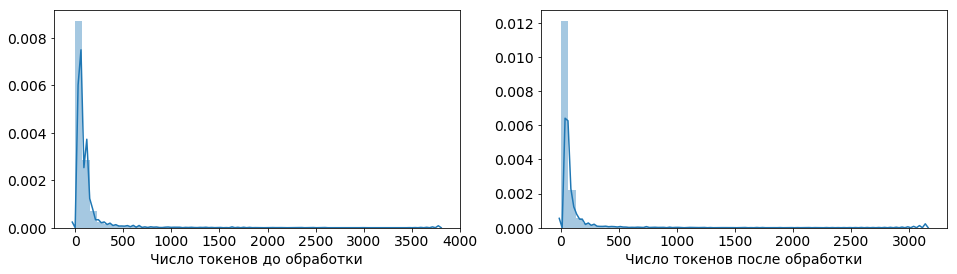

In [27]:
df_snow["num_tokens_raw"]  = df_snow["raw_description"].apply(lambda x: len(str(x).split())) 
df_snow["num_tokens_text"] = df_snow["text"].apply(lambda x: len(str(x).split())) 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
sns.distplot( df_snow["num_tokens_raw"], axlabel="Число токенов до обработки", ax=axes[0])
sns.distplot( df_snow["num_tokens_text"], axlabel="Число токенов после обработки", ax=axes[1]);

Мы частично отсекли "хвост" и сильно увеличили долю коротких описаний. Это должно упростить задачу нашей модели.

#### Посмотрим теперь на распределение целевой функции (20 наибольших значений)

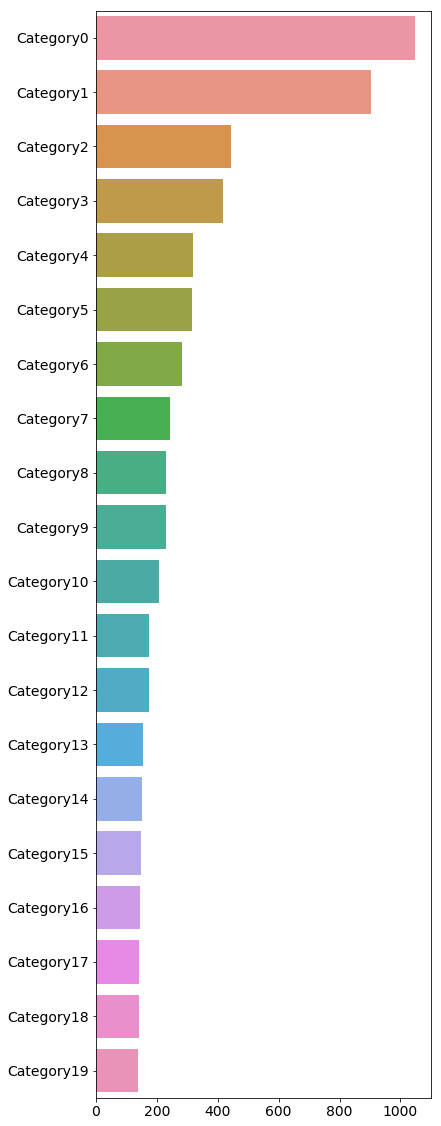

In [28]:
stat=df_snow["category"].value_counts()
# https://seaborn.pydata.org/examples/horizontal_barplot.html
y_labels = []
for i in range(0, len(stat)):
    y_labels.append("Category"+str(i))  

f, ax = plt.subplots(figsize=(6, 20))
sns.barplot( x=stat[:20].values, y=y_labels[:20]);

In [29]:
print("Уникальных категорий:", len(stat))

Уникальных категорий: 218


Названия категорий не указаны в качестве подписей из соображений NDA

Количественное распределение говорит нам о значительном дисбалансе классов - четверть заявок относится к трём классам, половина - к 10-13 классам. 

При этом нам надо максимизировать количество корректных предсказаний, а не обеспечить 100% полноты по всем классам. Т.е. если корректно выделять 10 классов из 200 - то уже половина работы будет сделана. Ошибки на редких классах при этом не так важны.

В такой ситуации вполне оправданно использовать метрику *accuracy* либо *f1_weighted* 

Для более детального анализа, при проверке качества выделения каждой из категорий, лучше использовать метрику f1. 
Кроме того, придётся ввести метрики "доля уверенно классифицированных" и "доля ошибок среди уверенных классификаций", потому что именно такие метрики соответствуют бизнес-задаче.

###  Часть 6. Создание новых признаков и описание этого процесса
В качестве признаков можно использовать счётчики количества вхождений в текст определённых ключевых слов или фраз. К примеру, слово "Skype" - достаточный признак для однозначной классификации. 

Поэтому подготовим файл с регулярными выражениями для поиска нужных ключевых слов такого вида:

| Имя признака  |Выражение|Комментарий|
|:-:|---|---|
|kw0046|спам|   |
|kw0102|(прогноз продажа)|Это про CRM|
|kw0068|телефон|   |
|kw0041|пароль|   |

Прочитаем нам список ключевых слов, посчитаем количество вхождений и сохраним их в датафрейм cfm_train

In [30]:
search_patterns = pd.read_csv("custom_features.csv", header=0,sep=";" )

cfm_snow = pd.DataFrame()
#search_patterns
custom_features = list()
for i in tqdm(search_patterns.iterrows()):
    #print(i[1].alias, i[1].pattern)
    cfm_snow[i[1].alias] = df_snow["text"].str.count(pat=i[1].pattern)
    custom_features.append(i[1].alias)
print("cfm_snow shape:", cfm_snow.shape)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


cfm_snow shape: (10000, 123)


In [31]:
cfm_snow[["SZ","RZ","Access","kw0004","kw0039","kw0075","kw0127"]].head(10)

,SZ,RZ,Access,kw0004,kw0039,kw0075,kw0127
0,0,0,0,0,0,0,0
1,3,0,0,0,0,1,0
2,0,0,2,0,0,2,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0
5,0,0,1,0,0,0,0
6,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0
8,0,0,0,0,0,1,0
9,0,0,0,0,0,0,0


Полученные таким образом признаки можно совмещать с мешком слов, а можно учиться только на них. Вариант склеивания прогнозов, полученных на мешке слов с новыми признаками и повторного обучения на склейке оказался совсем плохим. 

RandomForest на том наборе признаков, что готовы в проекте, дает f1_weighted 0.43. Более подробно на этом останавливаться я не буду.

###  Часть 7. Кросс-валидация, подбор параметров

#### Выбор модели
В качестве базового решения выбран SGDClassifier на мешке слов, который генерирует TFIDFVectoriser, потому что:
* это простое решение из  готовых компонентов
* эти компоненты работают быстро, как на обучение, так и на предсказание
* на заявках из старого service desk оно сходу даёт accuracy порядка 70%.

Кроме того в описаниях заявок иногда встречаются очень специфические слова-маркеры, которые позволяют с очень высокой точностью категоризировать заявку. Это хороший повод попробовать создать признаки вида "сколько раз слово-маркер вошло в описание" и обучить на них RandomForest (много логики типа "в тексте упоминается мышь - на техподдержку") и XGBoost (несколько сотен целочисленных признаков).

#### Разбиение на обучающую и отложенную выборку

Все преобразования сделаны до разбиения, но проблемы в этом нет: каждое преобразование производится в пределах одной заявки. В продуктиве поступающие заявки будут проходить те же самые преобразования. Так что никакого лика это не вызывает.

Разбиение лучше сделать, сохранив баланс по полю category. Для этого требуется, чтобы не было таких категорий, по которым есть меньше двух заявок (чтобы хотя бы по одной попало и в train, и в test). Поэтому отрежем "хвост" и осуществим разбиение таким образом:

In [32]:
vc = pd.DataFrame(df_snow["category"].value_counts())
vc = vc[vc["category"]<3]
df_snow.drop(df_snow.index[df_snow["category"].isin(vc.index)], axis=0, inplace = True)

train_data_snow, test_data_snow = train_test_split(df_snow,train_size=0.7, test_size=0.3, stratify=df_snow["category"], random_state=17)


При порборе гиперпараметров разбиение на фолды будем делать стратифицированное. Но для этого надо, чтобы записей каждого класса было не меньше, чем n_splits штук. Поэтому n_splits возьмём 3, а хвост обучающей выборки опять придётся подрезать.

In [33]:
vc = pd.DataFrame(train_data_snow["category"].value_counts())
vc = vc[vc["category"]<3]
train_data_snow.drop(train_data_snow.index[train_data_snow["category"].isin(vc.index)], axis=0, inplace = True)

#### Подготовка мешка слов

*stopwords.csv* - файл со стоп-словами, типа "добрый", "день", "спасибо", "кто" и так далее. Слова, которые совершенно точно не влияют на категоризацию, но слишком часто встречаются.
Можно было бы обойтись без этого списка, отрегулировав параметр max_df, но у нас есть важные для принятия решения слова частотой больше 0,9.

In [34]:
stop_list = pd.read_csv("stopwords.csv", encoding="utf8",header=None)
vectorizer_snow = TfidfVectorizer(min_df=2, max_df=1.0, ngram_range = (1, 3), stop_words=list(stop_list[0]))

X_train_snow = vectorizer_snow.fit_transform(train_data_snow["text"])

target_snow = train_data_snow["category"]

#### Подбор гиперпараметров и обучение 

У SGDClassifier в версиях 0.19 и 0.21 изменился набор параметров. Попробуем выбрать способ и коэффициент регуляризации и коэффициент скорости обучения.

In [35]:
if make_cv:
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=241)

    clf = SGDClassifier(max_iter=5000) #class_weight=snow_dict
    sgd_params = {'alpha':[1e-05, 1e-04,1e-03,0.01,0.1],
                  'penalty':['l1','l2'],
                  'loss': ['modified_huber'],
                  'tol' :[1e-04,1e-03],
                  'learning_rate': ["constant", "optimal","invscaling"],
                  'class_weight' : ["balanced", None],
                  'eta0' :[0.01,0.1,0.5, 0.9]
                 }
    gridCV = GridSearchCV(clf, param_grid=sgd_params, scoring='accuracy', cv=kfold, n_jobs=4, verbose=1)

    gridCV.fit(X_train_snow, target_snow)

    print(gridCV.best_params_)
    print(gridCV.best_score_)
    
#{'alpha': 0.0001, 'class_weight': None, 'eta0': 0.1, 'learning_rate': 'constant', 'loss': 'modified_huber', 'penalty': 'l1', 'tol': 0.0001}
#0.631852279284

#{'alpha': 0.0001, 'class_weight': None, 'eta0': 0.1, 'learning_rate': 'constant', 'loss': 'modified_huber', 'penalty': 'l1', 'tol': 0.0001}
#0.632140796307

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 16.6min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 38.9min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 68.0min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 130.9min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 216.6min
[Parallel(n_jobs=4)]: Done 1440 out of 1440 | elapsed: 253.3min finished


{'alpha': 0.0001, 'class_weight': None, 'eta0': 0.1, 'learning_rate': 'constant', 'loss': 'modified_huber', 'penalty': 'l1', 'tol': 0.0001}
0.633727639931


###  Часть 8. Построение кривых валидации и обучения 

Попробуем более точно подобрать параметр eta0:

HBox(children=(IntProgress(value=0, max=40), HTML(value='')))

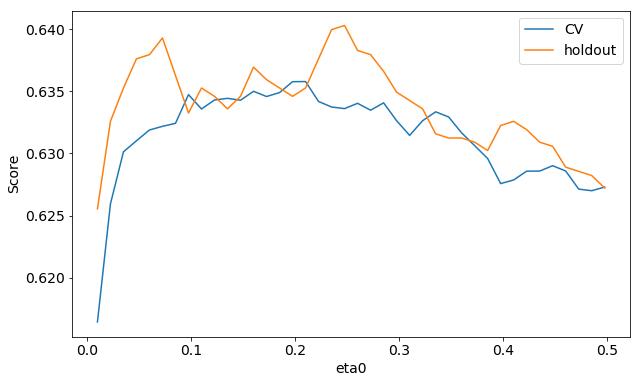

In [36]:
if make_cv:
    
    cv_scores, holdout_scores = [], []
    eta0_list = np.arange(0.01,0.5,0.0125)

    for k in tqdm(eta0_list):
        clf = SGDClassifier(max_iter=5000, 
                            alpha=0.0001, 
                            penalty="l1", 
                            loss="modified_huber", 
                            random_state=17, 
                            class_weight=None,
                            tol=0.0001,
                            learning_rate='constant',
                            eta0=k)
        clf.fit(X_train_snow, target_snow)
        holdout_scores.append(accuracy_score(test_data_snow["category"],
                                             clf.predict(vectorizer_snow.transform(test_data_snow["text"]))))

        cv_scores.append(np.mean(cross_val_score(clf, X_train_snow, target_snow, cv=3)))
        
    plt.plot(eta0_list, cv_scores, label='CV')
    plt.plot(eta0_list, holdout_scores, label='holdout')
    plt.ylabel("Score")
    plt.xlabel("eta0")
    plt.legend();

###  Часть 9. Прогноз для тестовой или отложенной выборки

In [37]:
clf_sgd_bow_snow = SGDClassifier(alpha= 1e-04,
                            penalty="l1",
                            loss="modified_huber",
                            random_state=17,
                            class_weight=None,
                            eta0 = 0.1, 
                            learning_rate="constant",
                            n_jobs=4,
                            max_iter=5000,
                            tol=0.0001)

print("Обучаем SGD на мешке слов")
t0 = time()

clf_sgd_bow_snow.fit(X_train_snow, target_snow)
train_time = time() - t0
print("Затраченное время: %0.3fs" % train_time)

Обучаем SGD на мешке слов
Затраченное время: 4.266s


In [38]:
print("Делаем прогноз")
t0 = time()
test_data_snow["predicted_bow"] = clf_sgd_bow_snow.predict(vectorizer_snow.transform(test_data_snow["text"]))
train_time = time() - t0
print("Затраченное время: %0.3fs" % train_time)

Делаем прогноз
Затраченное время: 0.528s


Как видите, модель действительно быстрая и метод *predict* для 3к заявок отрабатывает за 0,53 секунды.

Проверим стандартные метрики: accuracy и f1_weighted.

In [39]:
f1_df_snow = pd.DataFrame(test_data_snow["category"].value_counts())
f1_df_snow.rename(columns={"category":"count"},inplace=True)
f1_df_snow["threshold"] = pd.read_excel("data\\thresholds.xlsx")["threshold"]
f1_df_snow["metric_name"] = pd.read_excel("data\\thresholds.xlsx")["metric_name"]

print("f1_weighted:", str(f1_score(test_data_snow ["category"],test_data_snow ["predicted_bow"], average="weighted", labels=f1_df_snow.index)))
print("accuracy:", str(accuracy_score(test_data_snow ["category"],test_data_snow ["predicted_bow"])))

f1_weighted: 0.608732036435
accuracy: 0.635266510225


###  Часть 10. Оценка модели с описанием выбранной метрики
Результат примерно совпадает с полученным на кросс-валидации. Но просто взять получившуюся модель и поставить её в прод нельзя из-за очень низкой точности. 40% ошибок - это недопустимо.
Оптимистичное предположение о том, что мы сможем, обучившись на 7000 заявок, построить хорошую модель классификации на 218 категорий, оказалась несостоятельным.

Можно пробовать другие модели, а можно предположить что дело именно в соотношении мощности обучающей выборки и количества категорий. Второй вариант проверить проще, ведь у нас есть база заявок из CA ServiceDesk.
#### Подготовка данных и обучение модели на заявках из CA ServiceDesk
Произведём все те же самые операции:
* прочитаем выборку из Excel
* преобразуем тексты
* настроим гиперпараметры модели
* обучимся и сделаем прогноз
* посмотрим на его адекватность

In [44]:
df_ca = pd.read_excel("data/raw_export_ca.xlsx")
df_ca["summary"] = df_ca["summary"].astype("str")
df_ca["ref_num"] = df_ca["ref_num"].astype("str")
df_ca["description"].fillna(" ",inplace=True)
df_ca["raw_description"] = df_ca.apply(merge_summary_and_description, axis=1)
df_ca["raw_description"].fillna(" ", inplace=True)

In [45]:
print("Количество заявок из CA SD:", df_ca.shape[0])
print("Уникальных категорий:", len(df_ca["category"].value_counts()))

Количество заявок из CA SD: 50626
Уникальных категорий: 199


In [46]:
df_ca["text"] = df_ca["raw_description"].str.lower()
df_ca.replace(to_replace = {"text": cleaning_dict}, inplace = True, regex=True )

In [47]:
df_ca["text"].to_csv("data/df_ca_text.csv", encoding="utf-8")
!"C:\Users\agurevich\.local\bin\mystem" -cdl --fixlist C:\Users\agurevich\python\moose\data\ts_fixlist.txt C:\Users\agurevich\python\moose\data\df_ca_text.csv C:\Users\agurevich\python\moose\data\df_ca_text.out
df_ca["text"] = pd.read_csv("data/df_ca_text.out", header=None)[1]
df_ca["text"] = df_ca["text"].apply(remove_brackets)
df_ca["text"] = df_ca["text"].apply(remove_multispaces)
df_ca["text"].fillna(" ");

In [48]:
vc = pd.DataFrame(df_ca["category"].value_counts())
vc = vc[vc["category"]<3]
df_ca.drop(df_ca.index[df_ca["category"].isin(vc.index)], axis=0, inplace = True)

train_data_ca, test_data_ca = train_test_split(df_ca,train_size=0.7, test_size=0.3, stratify=df_ca["category"], random_state=17)

In [49]:
vc = pd.DataFrame(train_data_ca["category"].value_counts())
vc = vc[vc["category"]<3]
train_data_ca.drop(train_data_ca.index[train_data_ca["category"].isin(vc.index)], axis=0, inplace = True)

In [50]:
stop_list = pd.read_csv("stopwords.csv", encoding="utf8",header=None)
vectorizer_ca = TfidfVectorizer(min_df=2, max_df=1.0, ngram_range = (1, 3), stop_words=list(stop_list[0]))

X_train_ca = vectorizer_ca.fit_transform(train_data_ca["text"])

target_ca = train_data_ca["category"]

In [51]:
if make_cv:
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=241)

    clf = SGDClassifier(max_iter=5000) #class_weight=snow_dict
    sgd_params = {'alpha':[1e-05, 1e-04],
                  'penalty':['l1','l2'],
                  'loss': ['modified_huber'],
                  'tol' :[1e-04,1e-03],
                  'learning_rate': ["constant", "optimal","invscaling"],
                  'class_weight' : [None],
                  'eta0' :[0.05,0.1,0.2]
                 }
    gridCV = GridSearchCV(clf, param_grid=sgd_params, scoring='accuracy', cv=kfold, n_jobs=4, verbose=1)

    gridCV.fit(X_train_ca, target_ca)

    print(gridCV.best_params_)
    print(gridCV.best_score_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 30.0min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 105.0min
[Parallel(n_jobs=4)]: Done 216 out of 216 | elapsed: 114.5min finished


{'alpha': 1e-05, 'class_weight': None, 'eta0': 0.1, 'learning_rate': 'constant', 'loss': 'modified_huber', 'penalty': 'l1', 'tol': 0.001}
0.713982871195


Параметры получились те же самые, но score на кросс-валидации - 0,714 против 0,634

In [52]:
clf_sgd_bow_ca = SGDClassifier(alpha= 1e-05,
                            penalty="l1",
                            loss="modified_huber",
                            random_state=17,
                            class_weight=None,
                            eta0 = 0.1, 
                            learning_rate="constant",
                            tol=0.001,
                            n_jobs=4)


print("Обучаем SGD на мешке слов из старого SD")
t0 = time()

clf_sgd_bow_ca.fit(X_train_ca, target_ca)
train_time = time() - t0
print("Затраченное время: %0.3fs" % train_time)

Обучаем SGD на мешке слов из старого SD
Затраченное время: 18.693s


In [53]:
print("Делаем прогноз")
t0 = time()
test_data_ca["predicted_bow"] = clf_sgd_bow_ca.predict(vectorizer_ca.transform(test_data_ca["text"]))
train_time = time() - t0
print("Затраченное время: %0.3fs" % train_time)

Делаем прогноз
Затраченное время: 12.658s


In [54]:
f1_df_ca = pd.DataFrame(test_data_ca["category"].value_counts())
f1_df_ca.rename(columns={"category":"count"},inplace=True)
print("f1_weighted:", str(f1_score(test_data_ca ["category"],test_data_ca ["predicted_bow"], average="weighted", labels=f1_df_ca.index)))
print("accuracy:", str(accuracy_score(test_data_ca ["category"],test_data_ca ["predicted_bow"])))

f1_weighted: 0.712929557926
accuracy: 0.729980887102


Результат гораздо лучше, но нам надо давать прогнозы на другом наборе категорий, мы не можем использовать для этого получившуются модель. 

### Объединение датасетов

Очевидный следующий ход - попробовать объединить подборки заявок из двух ServiceDesk. К сожалению, нельзя просто взять и склеить два датасета из старого и нового ServiceDesk. Потому что у них сильно различаются классификаторы.

Например, была категория "Сети и связь.Интернет". Вместо неё стало две: "Доступ к сети Интернет@Предоставление доступа в сеть Интернет@" и "Доступ к сети Интернет@Поддержка доступа в сеть Интернет@".

Поэтому придётся провести большую работу по сопоставлению категорий и переклассификации заявок. Сейчас это примерно 270 строк правил в виде кода на Python, которые являются объектом коммерческой тайны и не могут быть опубликованы.

In [55]:
import moose_modules
df_ca, df_snow = moose_modules.reclassify_df(df_ca, df_snow)

Работа по сопоставлению ещё не завершена на 100%. Те заявки, по которым новая классфикация не опеределена, выбросим из рассмотрения. На этом мы потеряем примерно 13700 заявок.

In [56]:
print("Количество заявок из ServiceNow:", df_snow.shape[0])
print("Уникальных категорий в ServiceNow:", len(df_snow["category"].value_counts()))
print("Количество заявок из CA SD:", df_ca.shape[0])
print("Уникальных категорий в CA SD:", len(df_ca["category"].value_counts()))

Количество заявок из ServiceNow: 9476
Уникальных категорий в ServiceNow: 182
Количество заявок из CA SD: 36942
Уникальных категорий в CA SD: 52


Теперь надо подготовить обучающую и отложенную выборки. Важная особенность в том, что отложенная выборка должна максимально точно соответствовать ситуации в новом ServiceDesk, поэтому в неё мы отберём только заявки из df_snow. Минусом решения будет расхождение f1_weighted score на кросс-валидации и на отложенной выборке из-за разных распределений заявок по категориям. Возможно, будет лучше пользоваться accuracy.

In [57]:
vc = pd.DataFrame(df_snow["category"].value_counts())
vc = vc[vc["category"]<3]
df_snow.drop(df_snow.index[df_snow["category"].isin(vc.index)], axis=0, inplace = True)

train_data_merged, test_data_merged = train_test_split(df_snow,train_size=.3, stratify=df_snow["category"], random_state=17)
#df_both=pd.concat([df_ca, df_snow], ignore_index=True)
#train_data, test_data = train_test_split(df_both,train_size=.3, stratify=df_both["category"], random_state=17)

train_data_merged = pd.concat([df_ca, train_data_merged], ignore_index=True)

#train_data = train_data[train_data["category"].str.contains("@") ]
#test_data = test_data[test_data["category"].str.contains("@") ]

train_data_merged.reset_index(drop=True, inplace=True)
test_data_merged.reset_index(drop=True, inplace=True)


In [58]:
print("Количество заявок в train_data:", train_data_merged.shape[0])
print("Уникальных категорий в train_data:", len(train_data_merged["category"].value_counts()))
print("Количество заявок в test_data:", test_data_merged.shape[0])
print("Уникальных категорий в test_data:", len(test_data_merged["category"].value_counts()))

Количество заявок в train_data: 39780
Уникальных категорий в train_data: 177
Количество заявок в test_data: 6625
Уникальных категорий в test_data: 172


### Обучение на объединённом датасете

In [59]:
stop_list = pd.read_csv("stopwords.csv", encoding="utf8",header=None)
vectorizer_merged = TfidfVectorizer(min_df=2, max_df=1.0, ngram_range = (1, 3), stop_words=list(stop_list[0]))

X_train_merged = vectorizer_merged.fit_transform(train_data_merged["text"])

target_merged = train_data_merged["category"]

In [60]:
if make_cv:
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=241)

    clf = SGDClassifier(max_iter=5000) #class_weight=snow_dict
    sgd_params = {'alpha':[1e-05, 1e-04],
              'penalty':['l1','l2'],
              'loss': ['modified_huber'],
              'tol' :[1e-04,1e-03],
              'learning_rate': ["constant", "optimal","invscaling"],
              'class_weight' : [None],
              'eta0' :[0.05,0.1,0.2]
             }
    
    
    gridCV = GridSearchCV(clf, param_grid=sgd_params, scoring='accuracy', cv=kfold, n_jobs=4, verbose=1)

    gridCV.fit(X_train_merged, target_merged)

    print(gridCV.best_params_)
    print(gridCV.best_score_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 37.7min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 132.6min
[Parallel(n_jobs=4)]: Done 216 out of 216 | elapsed: 144.2min finished


{'alpha': 1e-05, 'class_weight': None, 'eta0': 0.2, 'learning_rate': 'constant', 'loss': 'modified_huber', 'penalty': 'l1', 'tol': 0.0001}
0.815912518854


In [61]:
!telegram-send "merged $gridCV.best_score_ $gridCV.best_params_"

Accuracy score на кросс-валидации - уже 0,816

In [62]:
clf_sgd_bow_merged = SGDClassifier(alpha= 1e-05,
                            penalty="l1",
                            loss="modified_huber",
                            random_state=17,
                            class_weight=None,
                            eta0 = 0.2, 
                            learning_rate="constant",
                            n_jobs=4)
print("Обучаем SGD на мешке слов из двух SD")
t0 = time()

clf_sgd_bow_merged.fit(X_train_merged, target_merged)
train_time = time() - t0
print("Затраченное время: %0.3fs" % train_time)

Обучаем SGD на мешке слов из двух SD
Затраченное время: 26.256s


In [63]:
print("Делаем прогноз")
t0 = time()
test_data_merged["predicted_bow"] = clf_sgd_bow_merged.predict(vectorizer_merged.transform(test_data_merged["text"]))
train_time = time() - t0
print("Затраченное время: %0.3fs" % train_time)

Делаем прогноз
Затраченное время: 11.631s


In [64]:
f1_df_merged = pd.DataFrame(test_data_merged["category"].value_counts())
f1_df_merged.rename(columns={"category":"count"},inplace=True)
print("f1_weighted:", str(f1_score(test_data_merged ["category"],test_data_merged ["predicted_bow"], average="weighted", labels=f1_df_merged.index)))
print("accuracy:", str(accuracy_score(test_data_merged ["category"],test_data_merged ["predicted_bow"])))

f1_weighted: 0.565044786048
accuracy: 0.600452830189


Вроде бы хотели как лучше, а получилось как обычно. Давайте разбираться, что с этими результатами делать.

Как вообще работает многоклассовая классификация? По большому счёту, мы имеем ответ модели вида:

|Название категории|Вероятность|
|---|---|
|Category1|0.12056546%|
|Category2|0.051566484%|
|Category3|0.754668788%|
|Category4|0.000000458%|
|...|...|
|Category210|0.0004565%|

Может быть, в тех ситуациях, когда одна из вероятностей сильно выше остальных - модель права? Нам ведь не надо делать прогнозы для 100% заявок. Нам надо делать как можно больше прогнозов с как можно меньшим количеством ошибок, мы можем иногда оставлять заявку на обработку человеку.

Поступим следующим образом: 
* методом *predict_proba* получим вероятности отнесения к каждому из классов (в сумме они равны единицы)
* максимальную вероятность назовем *max_proba*, следующую в порядке уменьшения - *second_proba*. Их разницу - *delta*, а их частное - *new_metric*
* для удобства добавим поле *bow_right*, где будет результат сравнения факта с прогнозом
* сделаем это для всех трёх моделей

In [65]:
df_temp = pd.DataFrame(np.sort(clf_sgd_bow_snow.predict_proba(vectorizer_snow.transform(test_data_snow["text"])), axis=1))

test_data_snow["max_proba"] = df_temp[df_temp.shape[1]-1]
test_data_snow["second_proba"] = df_temp[df_temp.shape[1]-2]    
test_data_snow["delta"] = test_data_snow["max_proba"] -  test_data_snow["second_proba"]   
test_data_snow["new_metric"] = test_data_snow["max_proba"]/test_data_snow["second_proba"]

#test_data["log_new_metric"] = np.log(test_data["max_proba"]/test_data["second_proba"]) / np.log(test_data["new_metric"][test_data["new_metric"]!=float("inf")].max())
test_data_snow["bow_right"] = (test_data_snow["category"] == test_data_snow["predicted_bow"])

In [66]:
df_temp_ca = pd.DataFrame(np.sort(clf_sgd_bow_ca.predict_proba(vectorizer_ca.transform(test_data_ca["text"])), axis=1))
test_data_ca["max_proba"] = df_temp_ca[df_temp_ca.shape[1]-1]
test_data_ca["second_proba"] = df_temp_ca[df_temp_ca.shape[1]-2]    
test_data_ca["delta"] = test_data_ca["max_proba"] -  test_data_ca["second_proba"]   
test_data_ca["new_metric"] = test_data_ca["max_proba"]/test_data_ca["second_proba"]

#test_data["log_new_metric"] = np.log(test_data["max_proba"]/test_data["second_proba"]) / np.log(test_data["new_metric"][test_data["new_metric"]!=float("inf")].max())
test_data_ca["bow_right"] = (test_data_ca["category"] == test_data_ca["predicted_bow"])

In [67]:
df_temp_merged = pd.DataFrame(np.sort(clf_sgd_bow_merged.predict_proba(vectorizer_merged.transform(test_data_merged["text"])), axis=1))
test_data_merged["max_proba"] = df_temp_merged[df_temp_merged.shape[1]-1]
test_data_merged["second_proba"] = df_temp_merged[df_temp_merged.shape[1]-2]    
test_data_merged["delta"] = test_data_merged["max_proba"] -  test_data_merged["second_proba"]   
test_data_merged["new_metric"] = test_data_merged["max_proba"]/test_data_merged["second_proba"]

#test_data["log_new_metric"] = np.log(test_data["max_proba"]/test_data["second_proba"]) / np.log(test_data["new_metric"][test_data["new_metric"]!=float("inf")].max())
test_data_merged["bow_right"] = (test_data_merged["category"] == test_data_merged["predicted_bow"])

Построим графики этих новых метрик для случаев, когда модель права и случаев, когда она ошиблась. Распределения почти совпадают, так что разделить их у нас не получится.

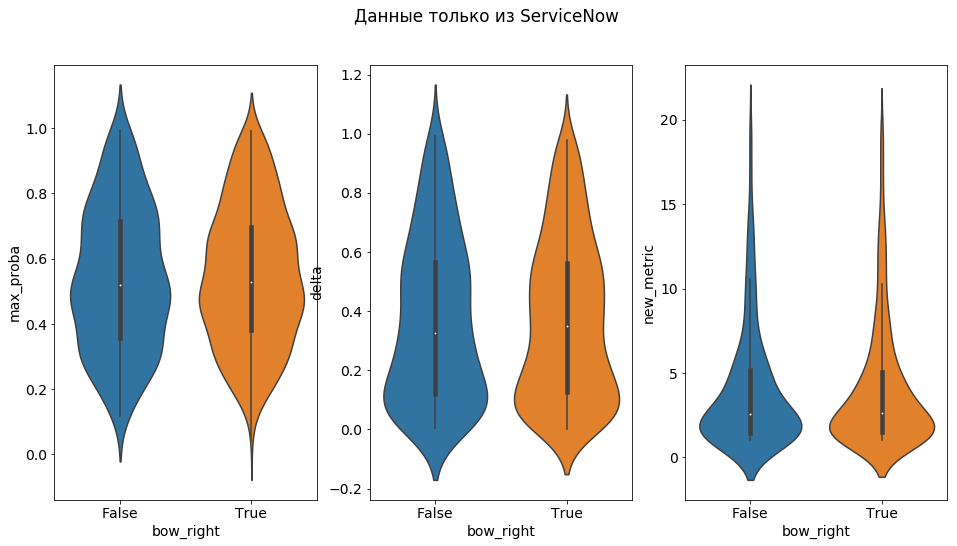

In [68]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))
plt.suptitle("Данные только из ServiceNow")
sns.violinplot(x=test_data_snow["bow_right"], y=test_data_snow["max_proba"], ax=axes[0])
sns.violinplot(x=test_data_snow["bow_right"], y=test_data_snow["delta"], ax=axes[1])
sns.violinplot(x=test_data_snow["bow_right"], y=test_data_snow[test_data_snow["new_metric"]<20]["new_metric"]);

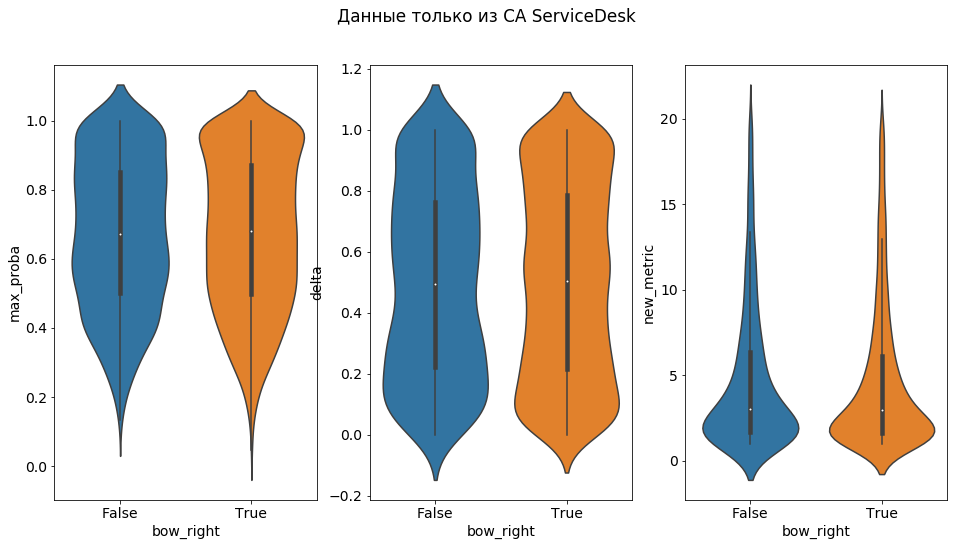

In [69]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))
plt.suptitle("Данные только из CA ServiceDesk")
sns.violinplot(x=test_data_ca["bow_right"], y=test_data_ca["max_proba"], ax=axes[0])
sns.violinplot(x=test_data_ca["bow_right"], y=test_data_ca["delta"], ax=axes[1])
sns.violinplot(x=test_data_ca["bow_right"], y=test_data_ca[test_data_ca["new_metric"]<20]["new_metric"]);

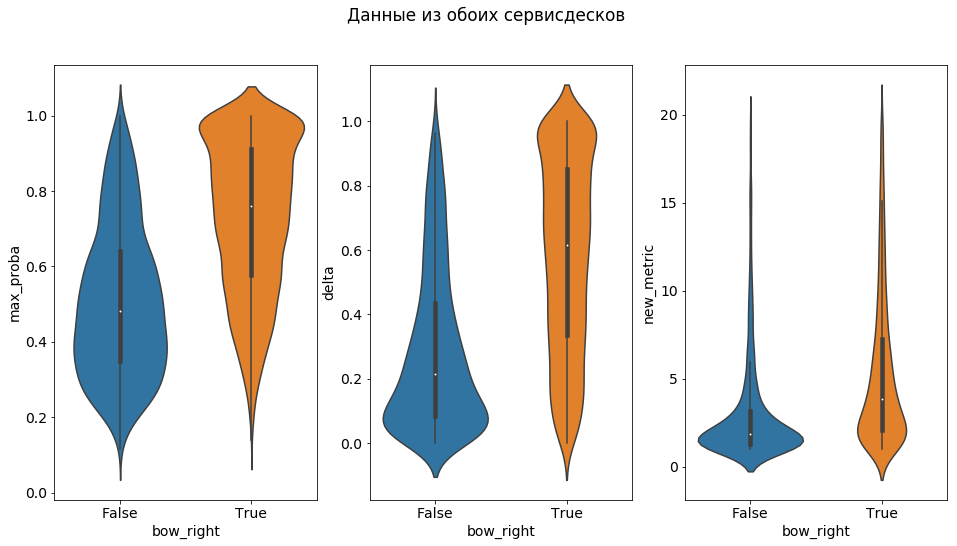

In [70]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))
plt.suptitle("Данные из обоих сервисдесков")
sns.violinplot(x=test_data_merged["bow_right"], y=test_data_merged["max_proba"], ax=axes[0])
sns.violinplot(x=test_data_merged["bow_right"], y=test_data_merged["delta"], ax=axes[1])
sns.violinplot(x=test_data_merged["bow_right"], y=test_data_merged[test_data_merged["new_metric"]<20]["new_metric"]);

И вот тут оказывается, что после объединения датасетов мы смогли, наконец, сделать утверждение "если спрогнозированная вероятность отнесения к классу высокая, то это, скорей всего, правда". А значит, мы уже можем отделять "уверенные прогнозы от неуверенных".

Посмотрим, что получится, если в качестве критерия уверенности принять "max_proba>0.8"

In [71]:
def check_custom_metrics(df):
    df["bow_is_sure_count"]=0
    df["bow_is_right_count"]=0
    test_data_merged["sure"]=False
    for cat_name in df.index:
        #print(cat_name)
        df.loc[cat_name,"bow_is_sure_count"] = test_data_merged[(test_data_merged[df.loc[cat_name, "metric_name"]]>df.loc[cat_name, "threshold"])
                                                &(test_data_merged["predicted_bow"]==cat_name) ].shape[0]
        test_data_merged["sure"][(test_data_merged[df.loc[cat_name, "metric_name"]]>df.loc[cat_name, "threshold"])
                                                &(test_data_merged["predicted_bow"]==cat_name) ]=True
        df.loc[cat_name,"bow_is_right_count"] = test_data_merged[(test_data_merged[df.loc[cat_name, "metric_name"]]>df.loc[cat_name, "threshold"])
                                                &(test_data_merged["predicted_bow"]==cat_name) 
                                                &(test_data_merged["predicted_bow"]==test_data_merged["category"])].shape[0]
    return df

In [72]:
f1_df_merged["threshold"] = 0.8
f1_df_merged["metric_name"] = "max_proba"


check_custom_metrics(f1_df_merged)

print("Прогнозов:", f1_df_merged["bow_is_sure_count"].sum())
print("Ошибок", f1_df_merged["bow_is_sure_count"].sum()-f1_df_merged["bow_is_right_count"].sum())
print("Процент прогнозов", f1_df_merged["bow_is_sure_count"].sum()/f1_df_merged["count"].sum())
print("Процент правильных", f1_df_merged["bow_is_right_count"].sum()/f1_df_merged["bow_is_sure_count"].sum())
f1_df_merged["acc"] = f1_df_merged["bow_is_right_count"]/f1_df_merged["bow_is_sure_count"]

Прогнозов: 1983
Ошибок 260
Процент прогнозов 0.299320754717
Процент правильных 0.868885526979


Многовато ошибок. Попробуем поднять порог до 0,9

In [73]:
f1_df_merged["threshold"] = 0.9

check_custom_metrics(f1_df_merged)

print("Прогнозов:", f1_df_merged["bow_is_sure_count"].sum())
print("Ошибок", f1_df_merged["bow_is_sure_count"].sum()-f1_df_merged["bow_is_right_count"].sum())
print("Процент прогнозов", f1_df_merged["bow_is_sure_count"].sum()/f1_df_merged["count"].sum())
print("Процент правильных", f1_df_merged["bow_is_right_count"].sum()/f1_df_merged["bow_is_sure_count"].sum())
f1_df_merged["predicted_part"] = f1_df_merged["bow_is_sure_count"]/f1_df_merged["count"]
f1_df_merged["accuracy_on_predicted"] = f1_df_merged["bow_is_right_count"]/f1_df_merged["bow_is_sure_count"]

Прогнозов: 1162
Ошибок 90
Процент прогнозов 0.175396226415
Процент правильных 0.922547332186


Ошибок стало меньше, но прогнозов стало совсем мало. Попробуем посмотреть на f1 score по категориям.

In [74]:
f1_df_merged["f1"] = f1_score(test_data_merged ["category"],test_data_merged ["predicted_bow"], 
                              average=None, labels=f1_df_merged.index)

f1_df_merged.index=np.arange(0,f1_df_merged.shape[0])

In [82]:
cm = sns.light_palette("#2ecc71", as_cmap=True)
s = f1_df_merged[["count","threshold","metric_name","f1","predicted_part","accuracy_on_predicted"]].style.background_gradient(cmap=cm)
s

,count,threshold,metric_name,f1,predicted_part,accuracy_on_predicted
0,725,0.6,max_proba,0.796865,0.808276,0.926621
1,559,0.65,max_proba,0.807413,0.830054,0.892241
2,308,8,new_metric,0.826421,0.435065,0.955224
3,265,8,new_metric,0.572422,0.932075,0.546559
4,208,8,new_metric,0.442177,0.00480769,1
5,188,8,new_metric,0.708972,0.361702,0.794118
6,183,8,new_metric,0.697892,0.415301,0.802632
7,164,2,new_metric,0.850575,0.939024,0.883117
8,151,8,new_metric,0.598592,0.0331126,1
9,130,8,new_metric,0.329412,0.00769231,1


Оказывается, что по одним категориям условие было слишком строгим, а по другим - недостаточным. Поэтому после небольшого анализа мы получили следующий набор метрик и порогов:

In [83]:
f1_df_merged = pd.DataFrame(test_data_merged["category"].value_counts())
f1_df_merged.rename(columns={"category":"count"},inplace=True)
f1_df_merged["threshold"] = pd.read_excel("data\\thresholds_ods.xlsx")["threshold"]
f1_df_merged["metric_name"] = pd.read_excel("data\\thresholds_ods.xlsx")["metric_name"]

check_custom_metrics(f1_df_merged)

print("Прогнозов:", f1_df_merged["bow_is_sure_count"].sum())
print("Ошибок", f1_df_merged["bow_is_sure_count"].sum()-f1_df_merged["bow_is_right_count"].sum())
print("Процент прогнозов", f1_df_merged["bow_is_sure_count"].sum()/f1_df_merged["count"].sum())
print("Процент правильных", f1_df_merged["bow_is_right_count"].sum()/f1_df_merged["bow_is_sure_count"].sum())
f1_df_merged["predicted_part"] = f1_df_merged["bow_is_sure_count"]/f1_df_merged["count"]
f1_df_merged["accuracy_on_predicted"] = f1_df_merged["bow_is_right_count"]/f1_df_merged["bow_is_sure_count"]

f1_df_merged["f1"] = f1_score(test_data_merged ["category"],test_data_merged ["predicted_bow"], 
                              average=None, labels=f1_df_merged.index)

f1_df_merged.index=np.arange(0,f1_df_merged.shape[0])

cm = sns.light_palette("#2ecc71", as_cmap=True)
s = f1_df_merged[["count","threshold","metric_name","f1","predicted_part","accuracy_on_predicted"]].style.background_gradient(cmap=cm)
s

Прогнозов: 2379
Ошибок 349
Процент прогнозов 0.359094339623
Процент правильных 0.853299705759


,count,threshold,metric_name,f1,predicted_part,accuracy_on_predicted
0,725,0.6,max_proba,0.796865,0.808276,0.926621
1,559,0.65,max_proba,0.807413,0.830054,0.892241
2,308,8,new_metric,0.826421,0.435065,0.955224
3,265,8,new_metric,0.572422,0.932075,0.546559
4,208,8,new_metric,0.442177,0.00480769,1
5,188,8,new_metric,0.708972,0.361702,0.794118
6,183,8,new_metric,0.697892,0.415301,0.802632
7,164,2,new_metric,0.850575,0.939024,0.883117
8,151,8,new_metric,0.598592,0.0331126,1
9,130,8,new_metric,0.329412,0.00769231,1


### Часть 11. Выводы 
Процент прогнозов вырос по сравнению с тривиальным условием max_proba>0.8, но немного вырос и ожидаемый процент ошибок.

Стоит учесть, что сейчас мы ошибкой считаем любое несовпадение прогноза с фактически указанным в отложенной выборке значением категории. И все ошибки считаем равнозначными. В реальности же при подробном рассмотрении списка ошибок выясняется, что:
* примерно треть несовпадений прогноза и факта являются ошибками людей, которые указали неправильную категорию при регистрации и не исправили это. При этом прогноз - верный
* треть - ошибки классификации, которые всё равно ведут к нужному назначению исполнителя. Т.е. если есть "Категория А" и "Категория Б", и по обеим исполнитель - Иванов Иван Иванович, в выборке указана "Категория А", а модель прогнозирует "Категория Б", то это ошибка, но гораздо меньшей цены, чем следующие два типа:
* по описанию даже человеку непонятно, что это за заявка, но модель выдаёт очень уверенный прогноз
* человеку очевидно, что за заявка, а модель даёт уверенный ошибочный прогноз

Одно из направлений дальнейшего развития - учитывать веса при оценке моделей.

#### Эксплуатация
Детальная проверка показала, что у разных категорий сильно отличается качество выделения. Некоторые категории модель выделяет с почти 90% точностью, а с некоторыми ошибается чаще, чем угадывает. Отсюда возникла идея вводить разные пороги уверенности для разных категорий. Кроме того, оказалось что и саму метрику, с которой сравнивать порог, лучше брать разную для разных категорий: либо max_proba, либо new_metric.

Была составлена таблица со списком категорий, используемой метрики и порогом метрики. При прогнозе мы получаем название категории, по  нему определяем используемую метрику, считаем значение метрики и, таким образом, определяем, уверена ли модель в выданном прогнозе

Заявки с уверенным прогнозом классифицируются в ServiceNow автоматически. С неуверенным - оставляются для ручной обработки.

Используемая сейчас в продуктиве версия модели позволяет уверенно классифицировать 46% заявок.

### Текущее состояние проекта (06.12.2017)
* PROD: Автоматически классифицируется 46% заявок. Это происходит с помощью одной модели, которая анализирует весь текст заявки. По каждой категории вручную подобран порог уверенности. Прогноз считается правильным, если вероятность отнесения заявки к спрогнозированной категории выше порога.
* DEV: Из полного текста заявки выделяем признаки, обучаем модели на них. Правила выделения признаков прописаны только частично, поэтому "проблему МФУ" и "предоставление доступа к дискам" такой подход определяет хорошо, а "бюджетирование" - пока никак.

### Дальнейшие направления развития проекта
#### Очистка данных, выделение признаков
* Разобраться, как можно использовать неуверенно распознанные токены (часть как признаки для моделей, часть в стоп-лист).
* Часто пользователи присылают скриншот ошибки в каком-то приложении без описания. Надо распознавать хотя бы приложение - это позволить классифицировать хотя бы часть таких заявок.

#### Развитие моделей
* Подбор порогов уверенности по категорям сделать не ручным, а автоматическим с поиском оптимального значения. 
* Выделяемыми признаками покрыть все категории заявок, создать полноценную модель классификации на них.
* Создать схему голосования моделей или усреднения их прогнозов. Возможно, это повысит качество прогнозов.
* Учитывать веса ошибок при оценке моделей


#### Организационные меры
* Упростить каталог услуг, сократить количество элементов в нём